In [5]:
import os, re, pickle
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [1]:
def build_data(data, x_len, y_len, gap=1):
    """
        Generates input-output pairs for multi-step time series forecasting.
        Args:
            data (np.ndarray): Array of shape (T, n_features) representing the time series.
            x_len (int): Length of the input window (number of past time steps).
            y_len (int): Length of the output window (forecast horizon).
            gap (int, optional): Number of time steps between input and output windows. Default is 1.

        Returns:
            x (np.ndarray): Array of input windows with shape (num_samples, x_len, n_features).
            y (np.ndarray): Array of output windows with shape (num_samples, y_len, n_features).

        Each sample consists of an input sequence (x) and a target sequence (y), separated by a gap.
    """
    
    x = []
    y = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len + gap, length):
        xtime = data[end_idx-y_len-x_len-gap:end_idx-y_len-gap]
        ytime = data[end_idx-y_len:end_idx]
        x.append(xtime)
        y.append(ytime)
    x = np.stack(x)
    y = np.stack(y)
    return x, y

# **File**

In [3]:
data_dict = {}

# **Wind speed**

In [2]:
dataSets = ["./Data/DS1_1440.csv", "./Data/DS2_1448.csv", 
            "./Data/UMAPCDDA/Argone_IL.txt", "./Data/UMAPCDDA/Beijing_Airport_China 2.txt", "./Data/UMAPCDDA/Chengdu_Airport_China.txt",
            "./Data/Using Fusion Models for Forecasting of Wind Speed and Direction/dataset.pkl"]

names_DB = ["Etiopia-April", "Etiopia-May", "Argone", "Beijing", "Chengdu", "Netherland"]


 Read data ------------------------------ 
	  DS1_1440.csv
13.665300369262695
(1433, 5) (1433, 1)


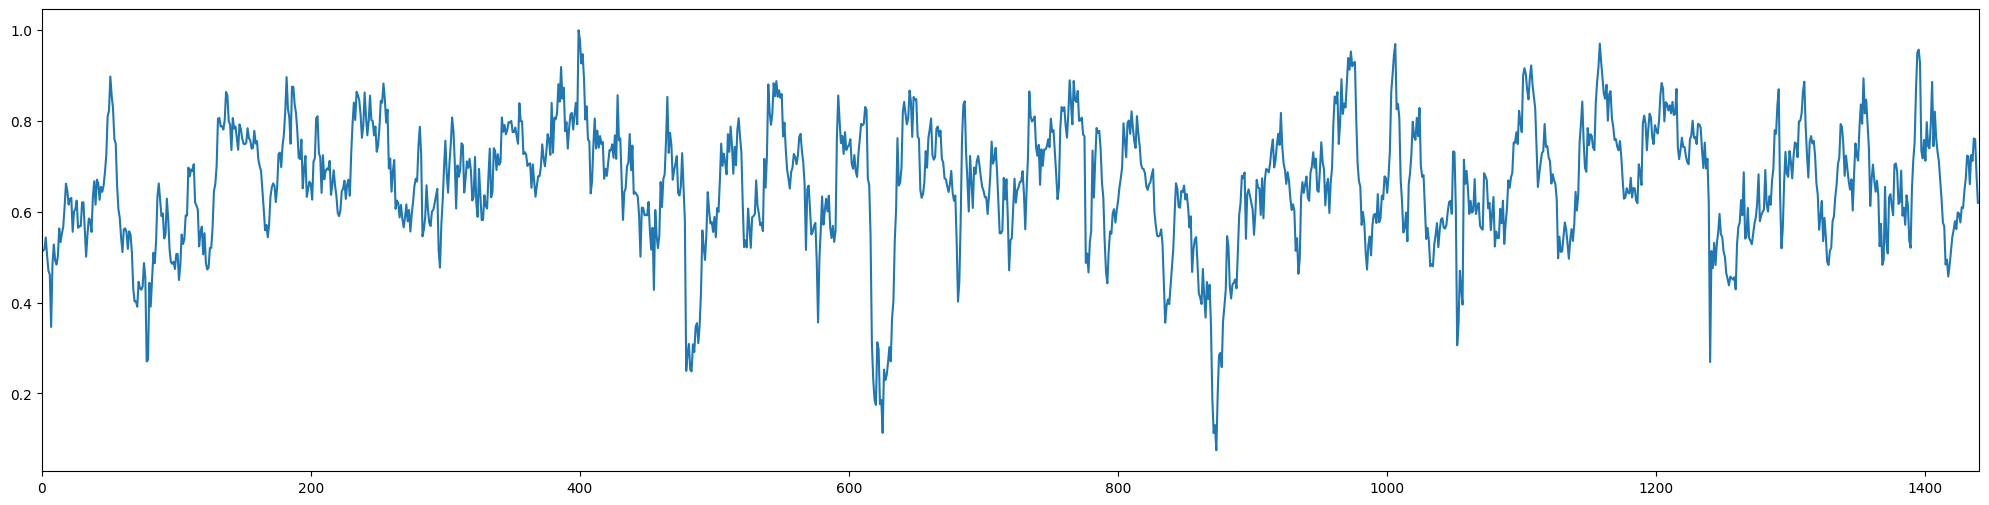


 Read data ------------------------------ 
	  DS2_1448.csv
12.142999649047852
(1481, 5) (1481, 1)


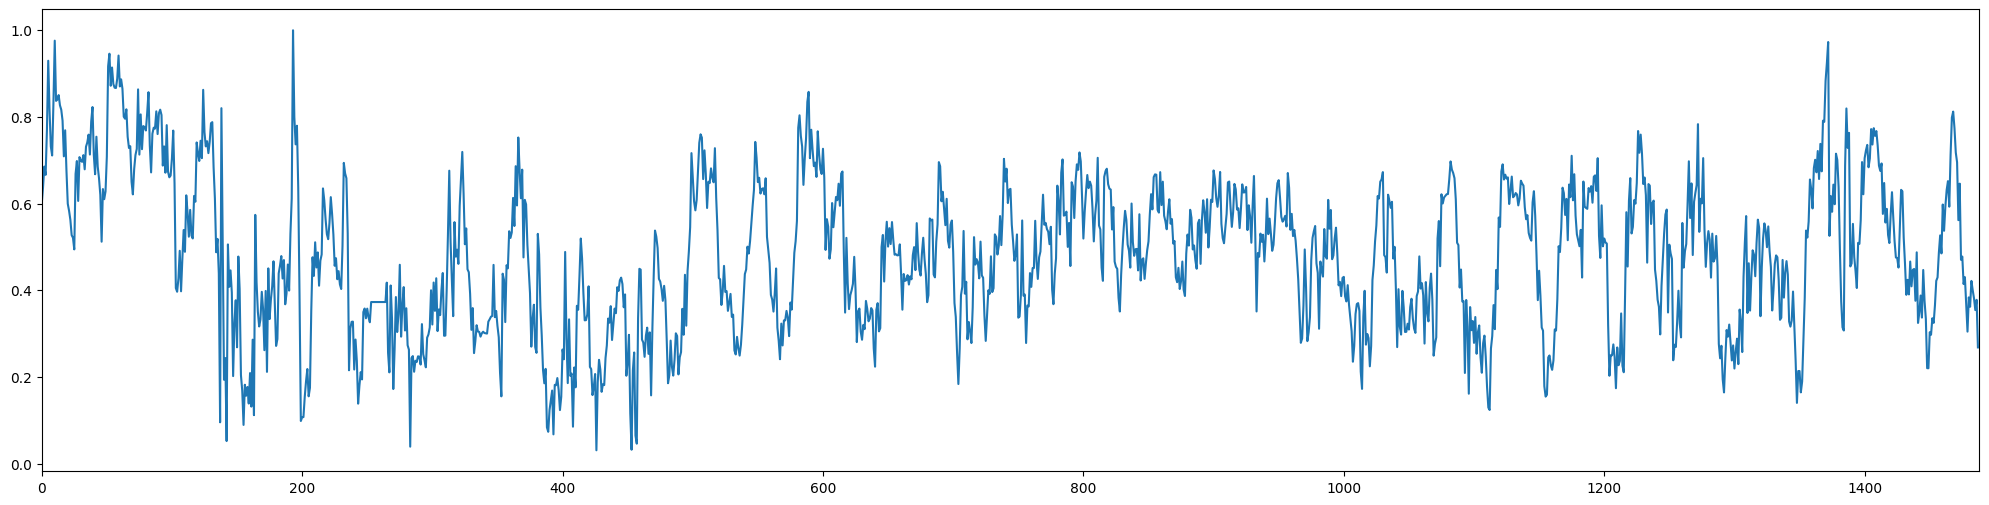


 Read data ------------------------------ 
	  Argone_IL.txt
32.44
(67892, 20) (67892, 7)


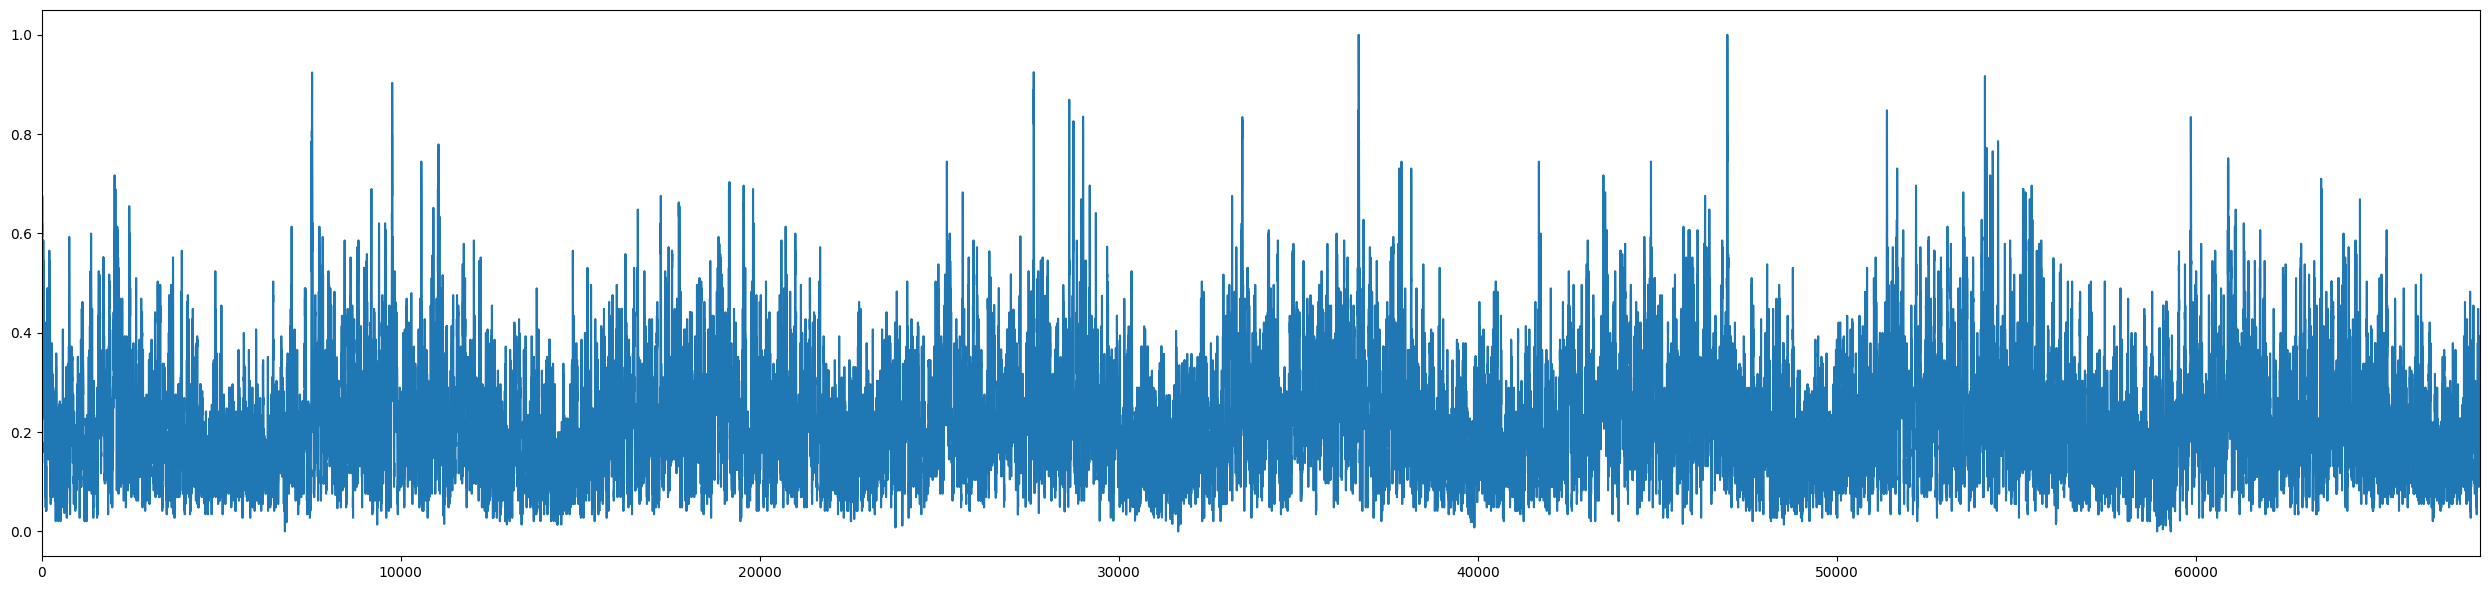


 Read data ------------------------------ 
	  Beijing_Airport_China 2.txt
1.0
(67892, 20) (67892, 7)


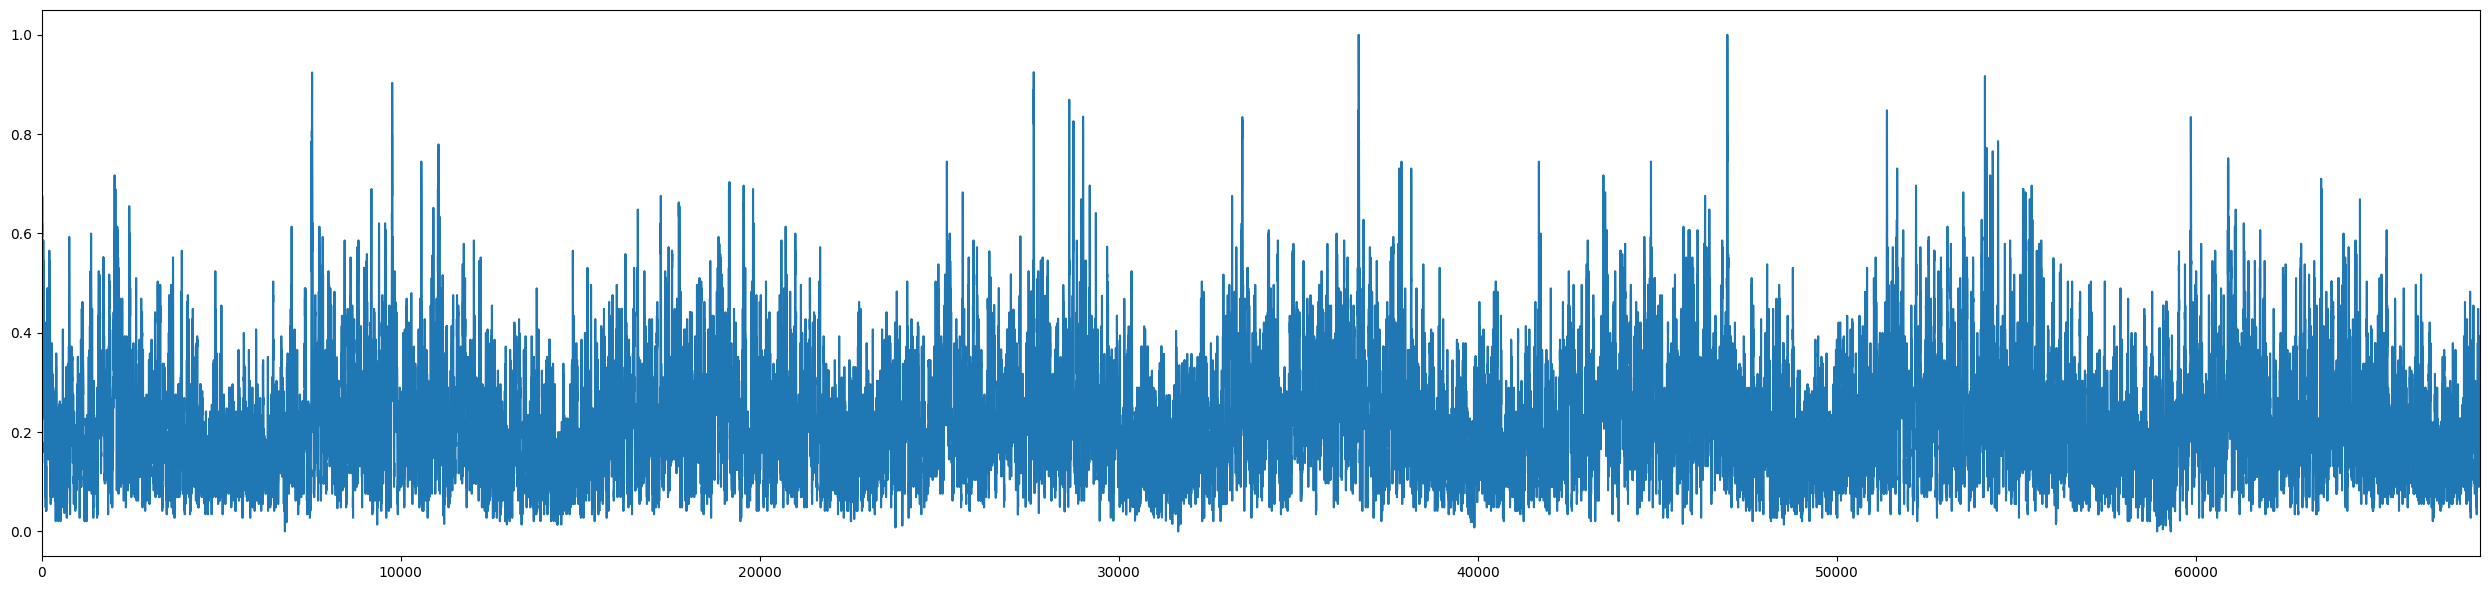


 Read data ------------------------------ 
	  Chengdu_Airport_China.txt
33.53
(69685, 20) (69685, 7)


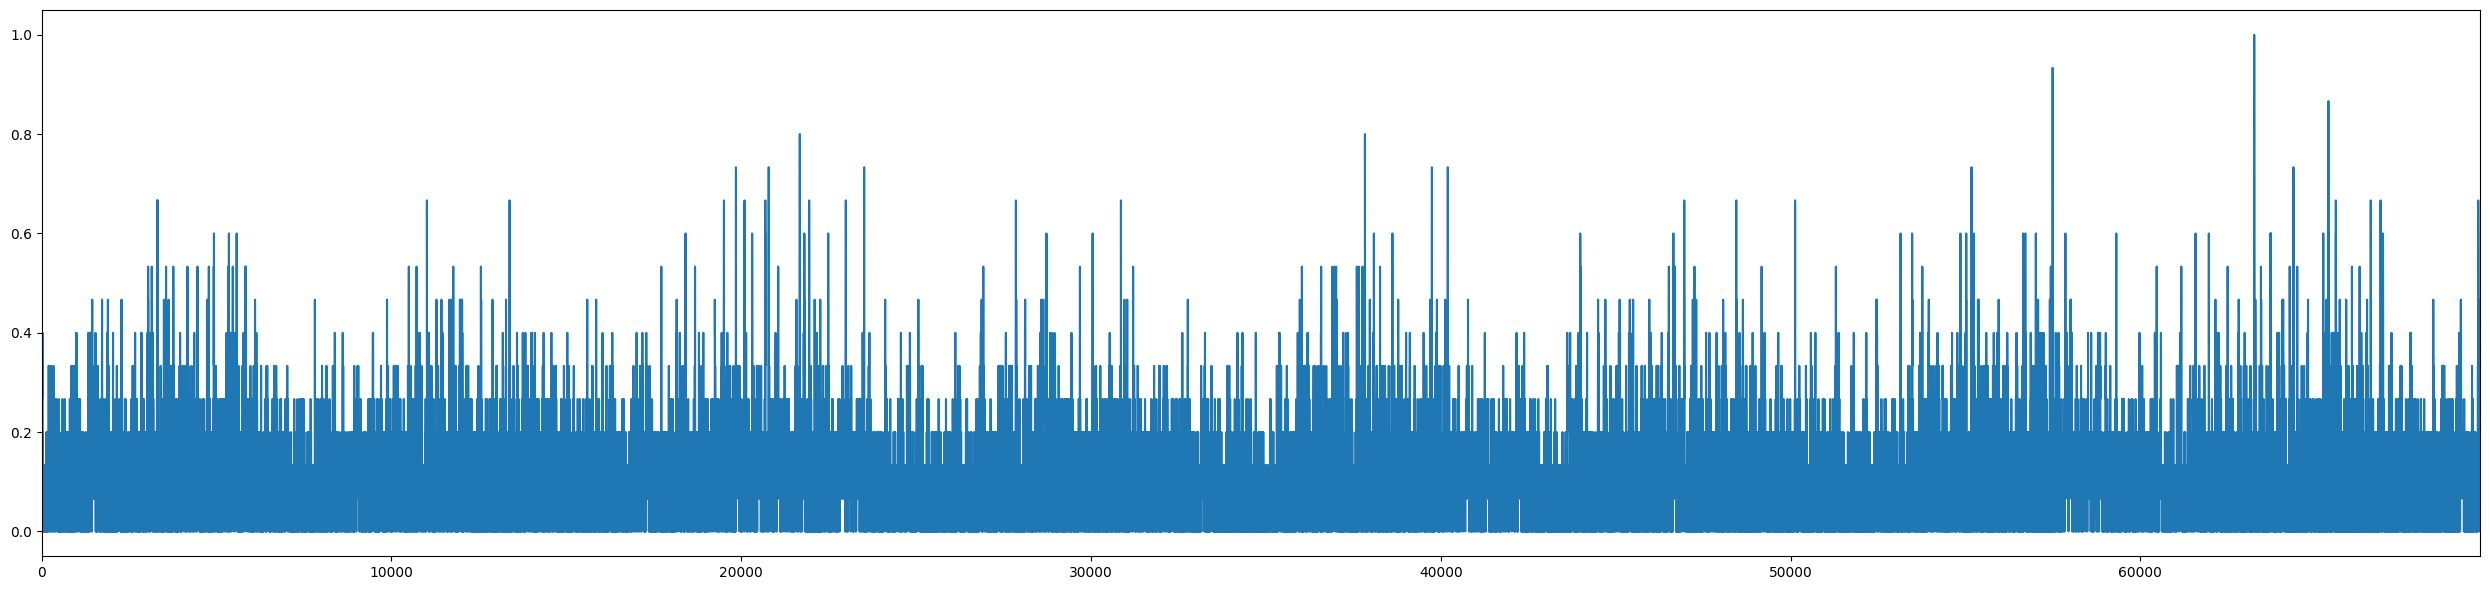


 Read data ------------------------------ 
	  dataset.pkl
1.0
(80979, 10) (80979, 10)


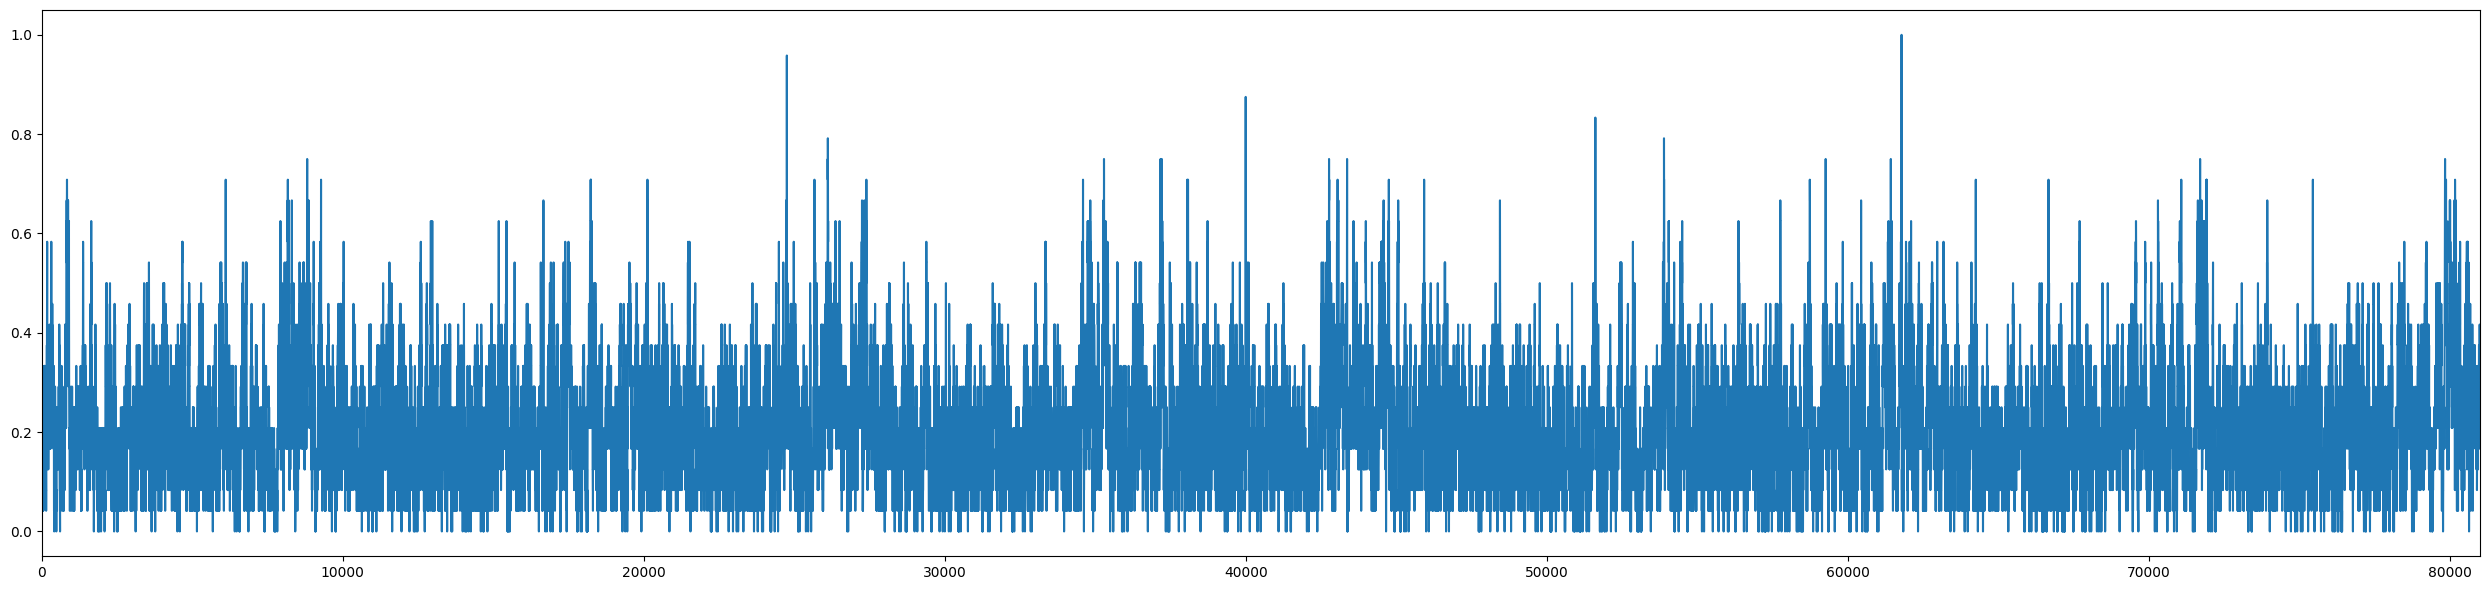

1.0
(80979, 10) (80979, 10)


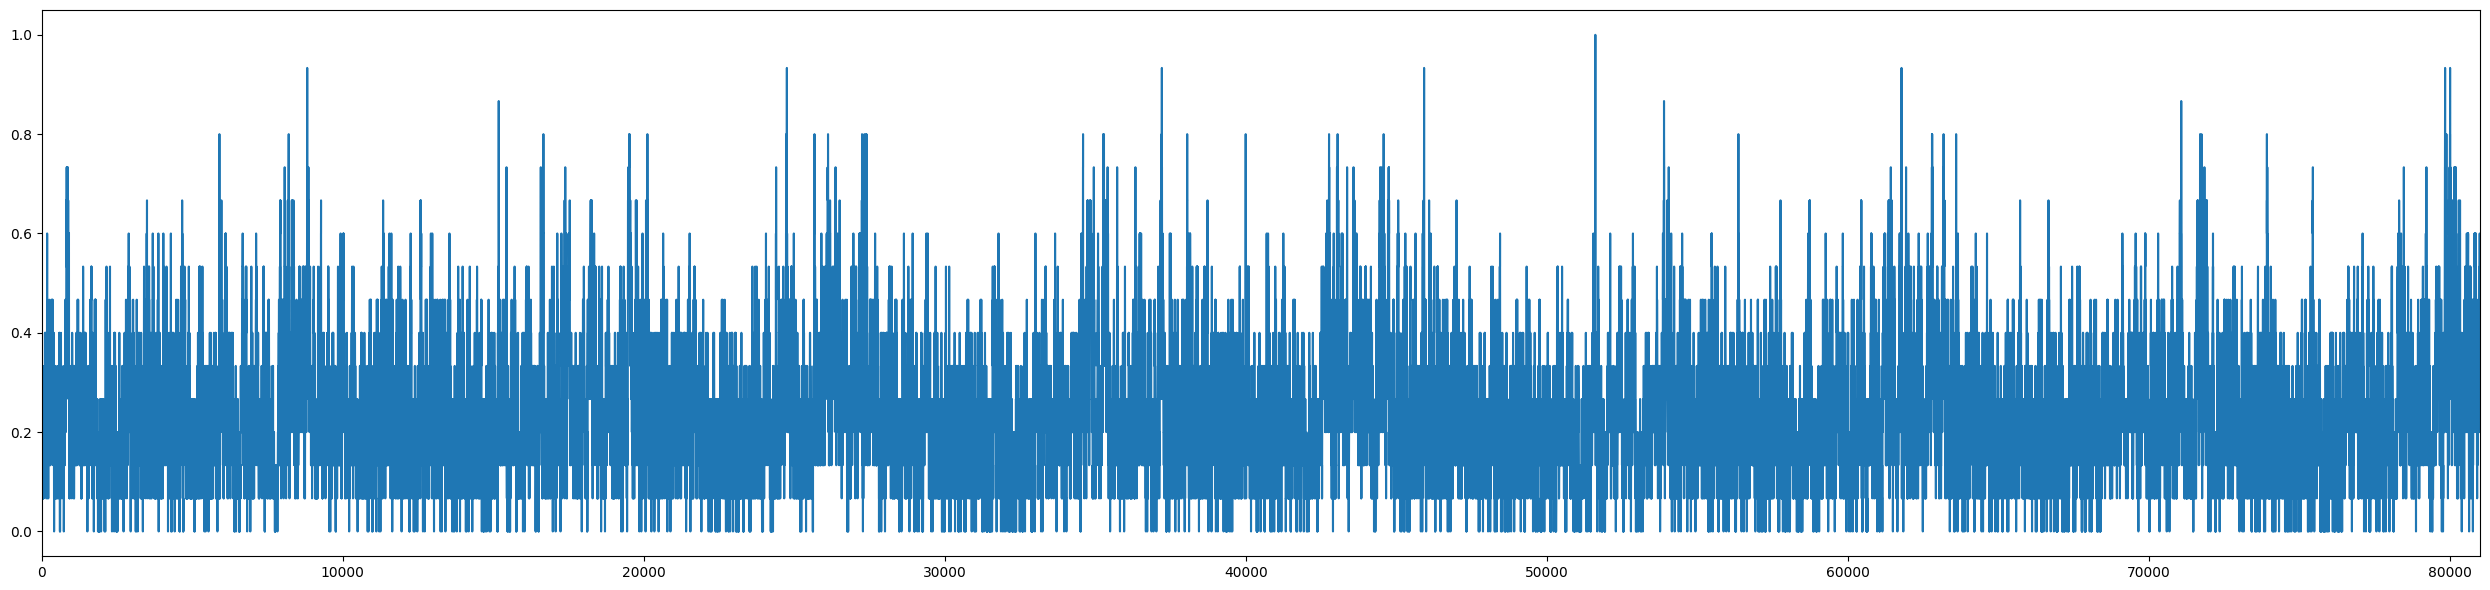

1.0
(80979, 10) (80979, 10)


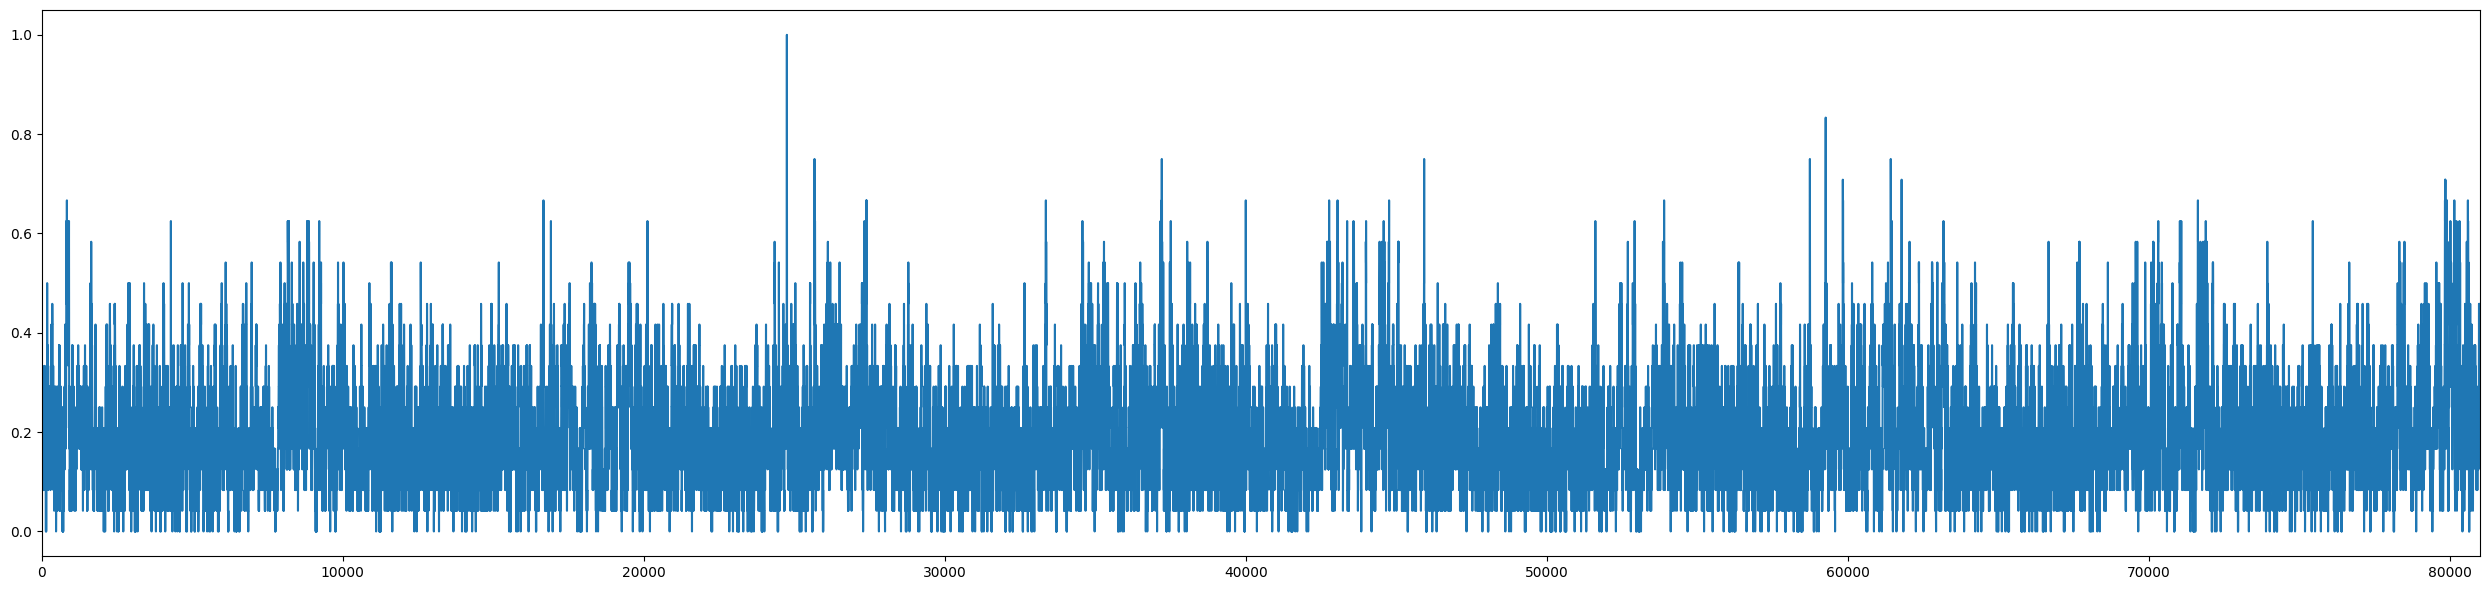

1.0
(80979, 10) (80979, 10)


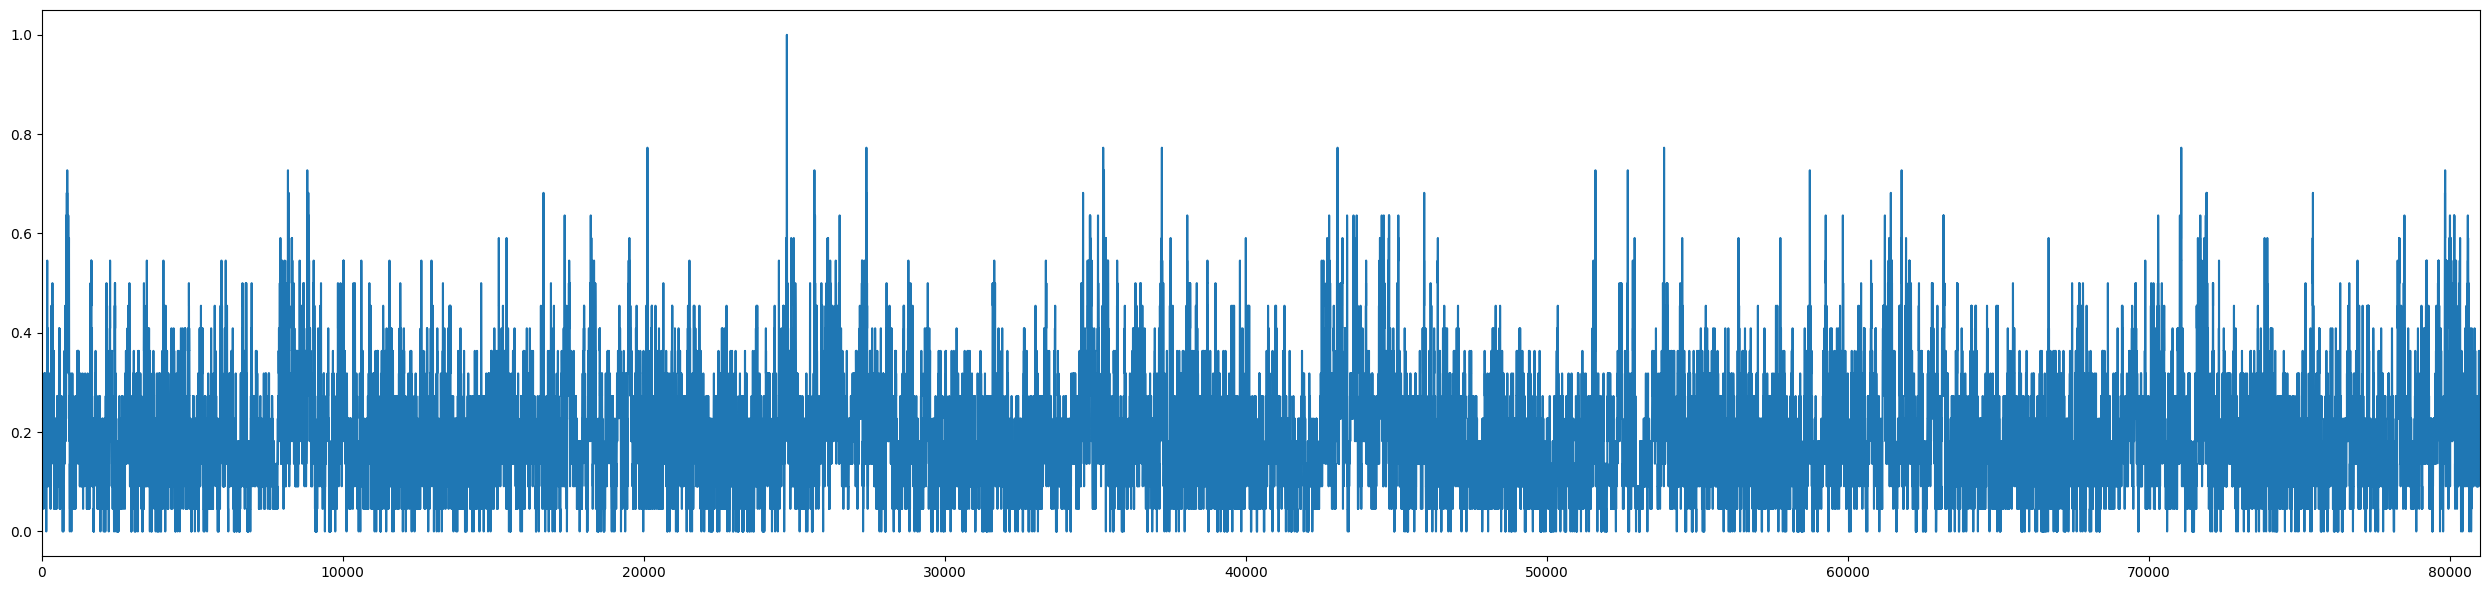

1.0
(80979, 10) (80979, 10)


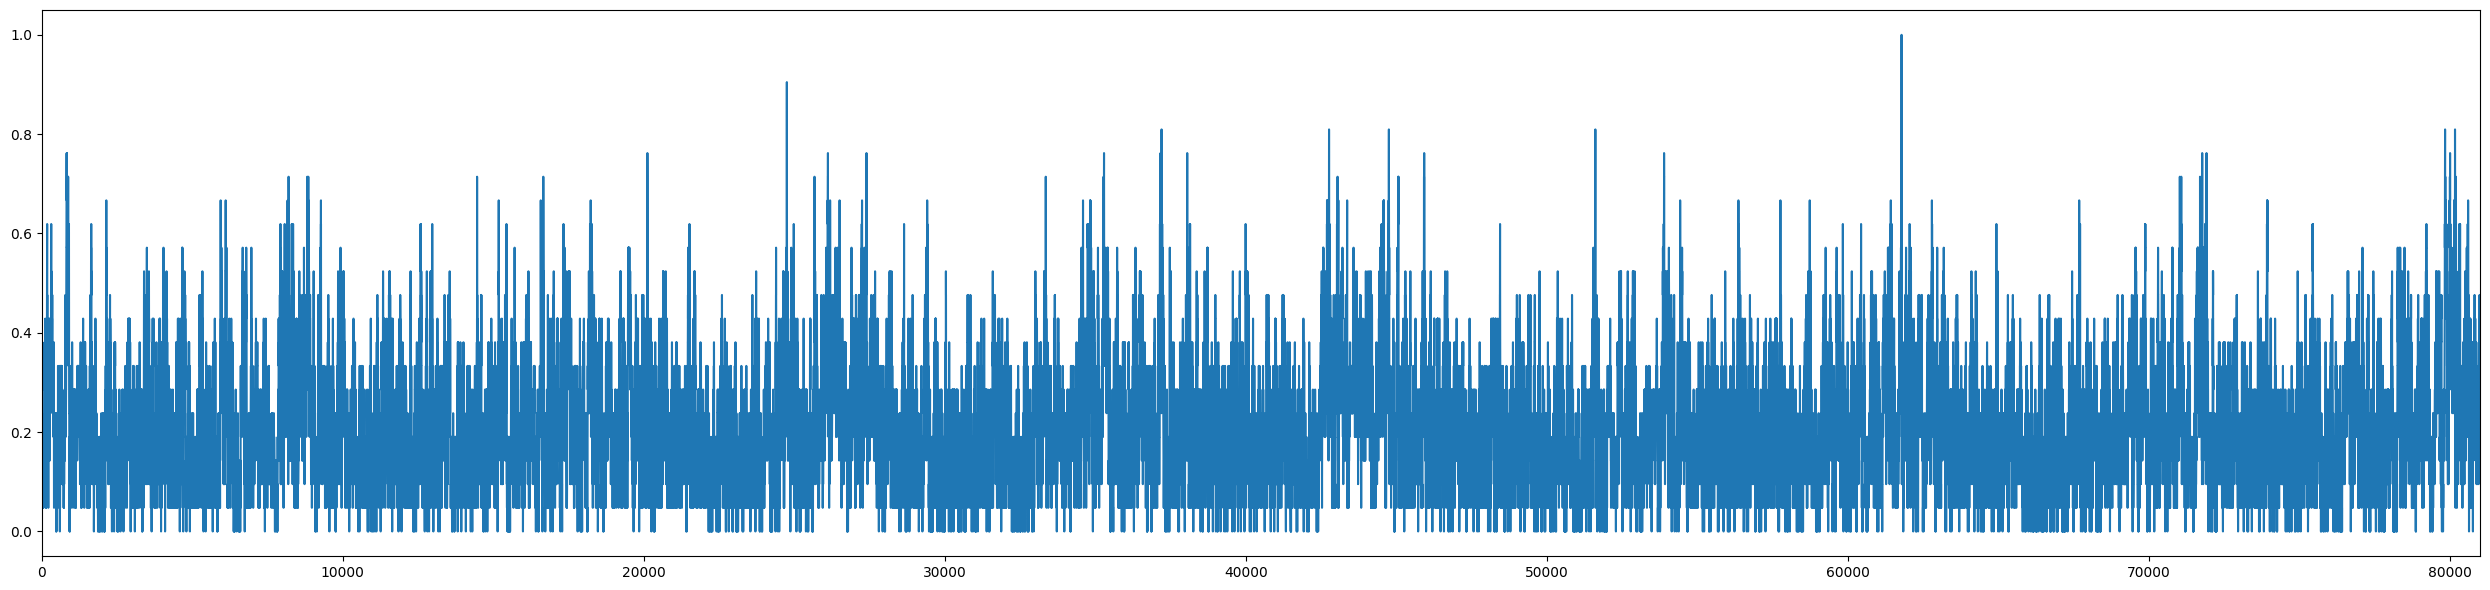

1.0
(80979, 10) (80979, 10)


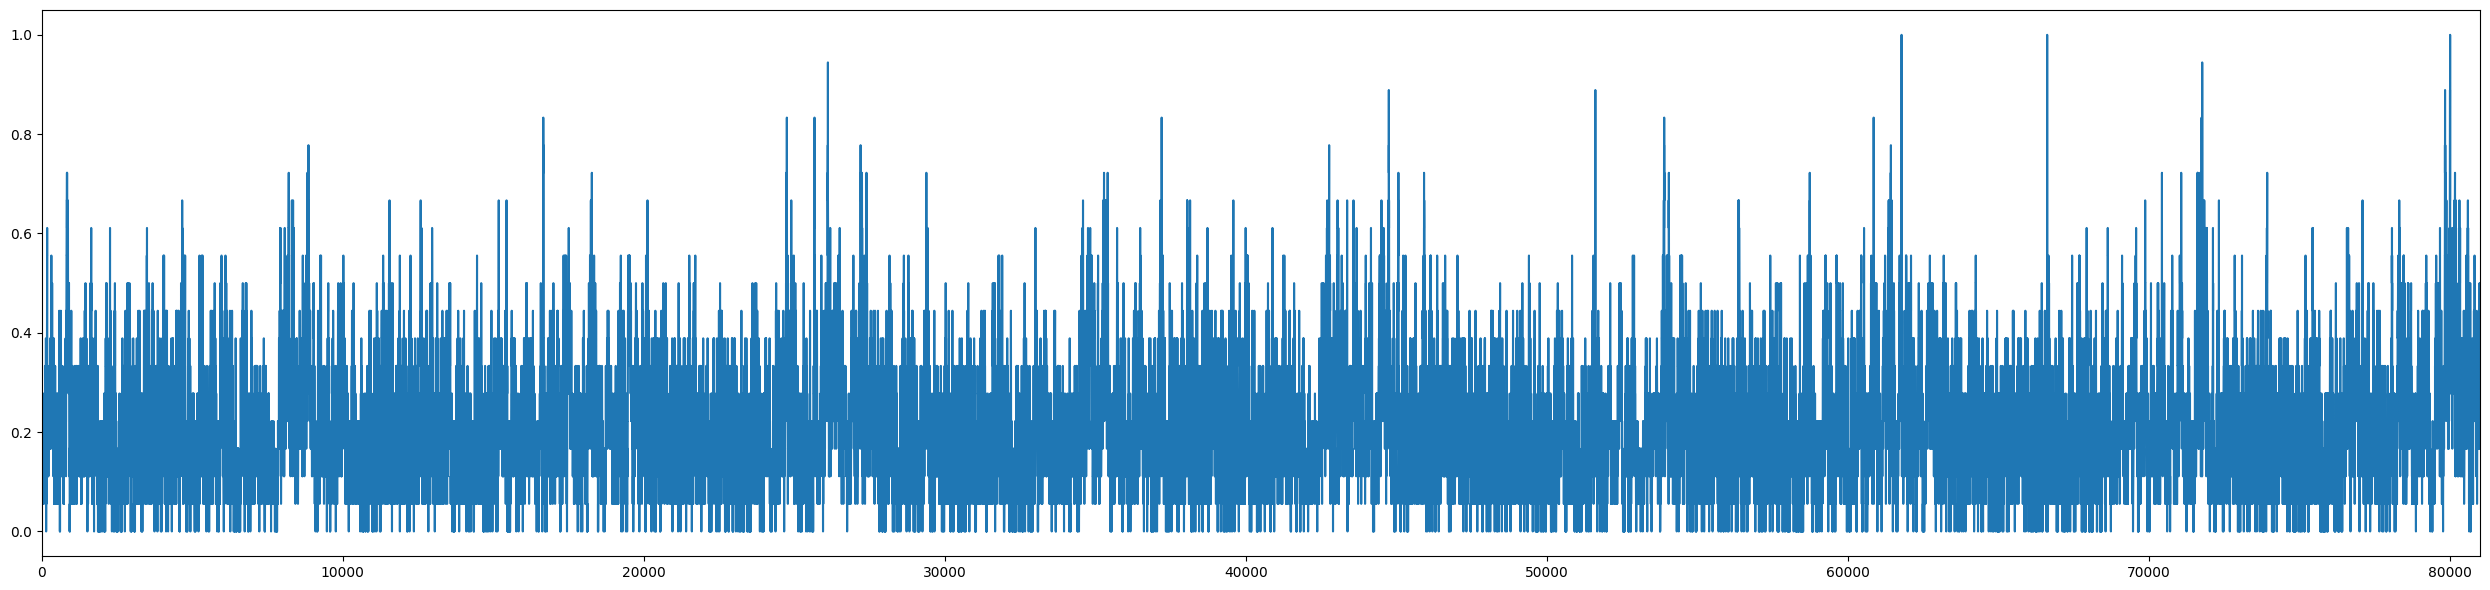

1.0
(80979, 10) (80979, 10)


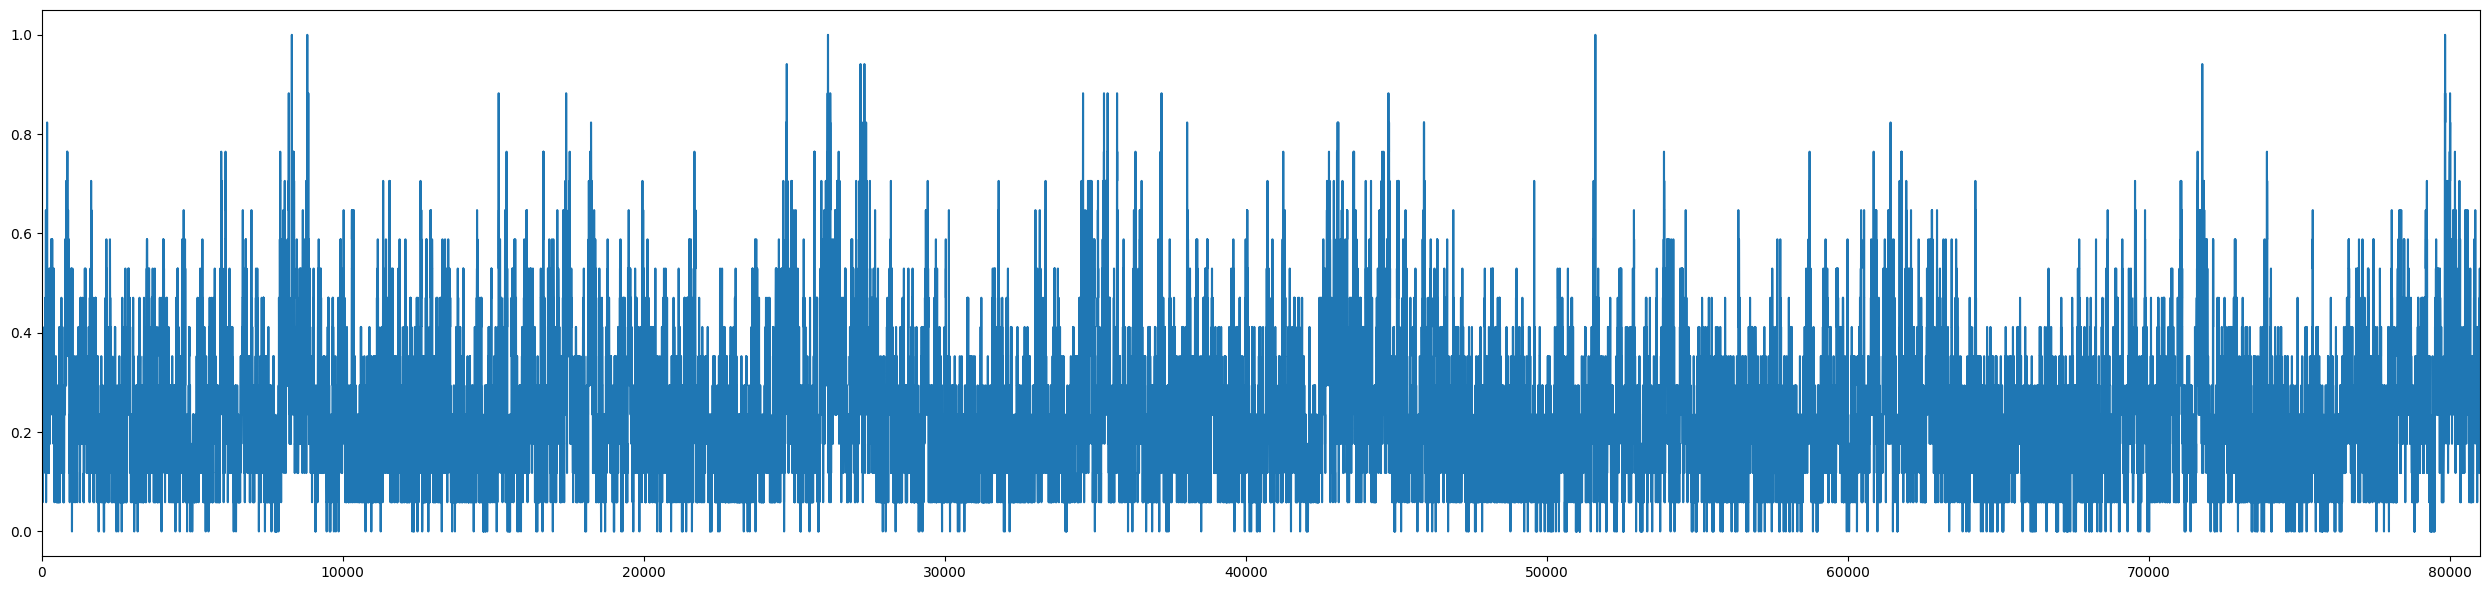

In [7]:
flag = 0 
for file_path in dataSets:
    
    file_names = re.search(r'[^/\\]+$', file_path).group()
    label = file_names[-3:]
    name_DB = names_DB[flag]
    flag += 1

    print(f"\n Read data ------------------------------ \n\t  {file_names}")

    if label == "csv":        
        df = pd.read_csv(file_path)
        col = None
        if 'wind_speed' in df.columns:
            col = 'wind_speed'
            tau  = 5
            tau_ = 1
        elif 'Speed' in df.columns:
            col = 'Speed'
            tau  = 15
            tau_ = 7
        else:
            continue

        values = df[col]
        n_nan = values.isnull().sum()

        max_ = max(values)
        print(max_)
        values = values/max_

        if n_nan == 0:
            X, Y = build_data(values, tau, tau_)
            fragment_to_use = values
            print(X.shape, Y.shape)
            data_dict[name_DB] = {'X': X, 'Y': Y}

        else:
            mask = values.notna()
            group = (mask != mask.shift()).cumsum()
            non_nan_groups = values[mask].groupby(group[mask])

            group_sizes = [(g, len(non_nan_groups.get_group(g))) for g in non_nan_groups.groups]

            if len(group_sizes) > 0:
                longest_idx, longest_segment = max(group_sizes, key=lambda x: x[1])
                values = non_nan_groups.get_group(longest_idx).to_numpy()

                if len(values) > (tau + tau_):
                    X, Y = build_data(values, tau, tau_)
                    print(X.shape, Y.shape)
                    data_dict[name_DB] = {'X': X, 'Y': Y, "Max": max_}
        
        plt.figure(figsize=(25, 6))
        plt.plot(values)
        plt.xlim(0, len(values))
        plt.show()

    elif label == "txt":
        tau  = 20
        tau_ = 7
        if file_names == "Argone_IL.txt":
            df = pd.read_csv(file_path, sep="\t",  names=['yyyymmdd','hhmn','mph','code'])
            df = df[df["yyyymmdd"] >= 19980101]
            df["sped"] = pd.to_numeric(df["mph"], downcast="float")
            timeSerie = df.iloc[:,2].values
        elif file_names == "Beijing_Airport_China2.txt":
            df = pd.read_csv(file_path, delimiter=",")
            df["sped"] = pd.to_numeric(df["sped"], downcast="float")
            timeSerie = df.iloc[:,1].values
        elif file_names == "Chengdu_Airport_China.txt":    
            df = pd.read_csv(file_path, sep=",")
            df["sped"] = pd.to_numeric(df["sped "], downcast="float")
            timeSerie = df.iloc[:,2].values
        
        max_ = max(timeSerie)
        print(max_)
        timeSerie = timeSerie/max_
        X, Y = build_data(timeSerie, tau, tau_)
        print(X.shape, Y.shape)
        data_dict[name_DB] = {'X': X, 'Y': Y, "Max": max_}

        plt.figure(figsize=(25, 6))
        plt.plot(timeSerie) 
        plt.xlim(0, timeSerie.shape[0])
        plt.tight_layout()
        plt.show()
        
    elif label == "pkl":
        tau  = 10
        tau_ = 10
        with open(file_path, "rb") as f:
            data = pickle.load(f)

        # data: Timesteps x Cities x Features        
        i_wind = 0  

        for city in range(data['train'].shape[1]):
            values = np.concatenate([data['train'][:, city, i_wind], data['test'][:, city, i_wind]]) 
            max_ = max(values)

            values = values/max_

            print(max(values))
    
            X, Y = build_data(values, tau, tau_)
            print(X.shape, Y.shape)
            data_dict[f"{name_DB}-{city}"] = {'X': X, 'Y': Y, "Max": max_}

            plt.figure(figsize=(25, 6))
            plt.plot(values)
            plt.xlim(0, values.shape[0])
            plt.tight_layout()
            plt.show()

